# Primary and Secondary Hand

For understanding the code in detail, please refer to the  [PD_classification_Kamble](PD_classification_Kamble.ipynb) notebook.

We used the Dataset from Studium.

In [1]:
# import module
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.morphology import skeletonize
from numba.typed import List
from utils import thin_spiral_image_with_custom_cut, find_spiral_point, \
         trace_spiral, get_angle_dist2, angle_cont_func, plt_traced
from scipy import signal
from scipy.ndimage import gaussian_filter1d

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error,  make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.utils import shuffle

import random

In [2]:
def feature_metric(x1, x2):
    return mean_squared_error(x1, x2, squared=False)

In [3]:

# Store Pdf with convert_from_path function
images = convert_from_path(r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\new_data\left-right-spirals.pdf')
#images = convert_from_path(r'/Users/linusfalk/Dev/AIA/AIA/left-right-spirals.pdf')


In [4]:
df = {}
iterations = [60, 640, 1170, 1730, 2400]
left_right = [200, 800, 1500]
for i in range(len(images)):
    for rl in range(2):
        for it in range(4):
            df['p{:02}_{}_{}'.format(i, rl, it)] = np.array(images[i])[iterations[it]:iterations[it+1], left_right[rl]:left_right[rl+1]]


p00_0_0


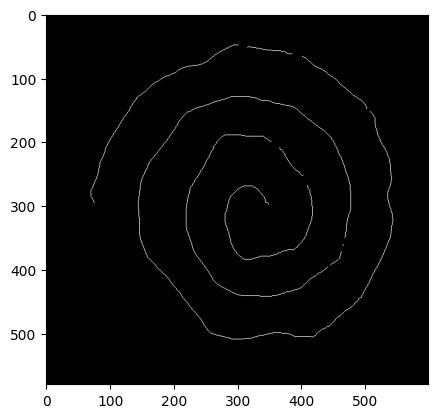

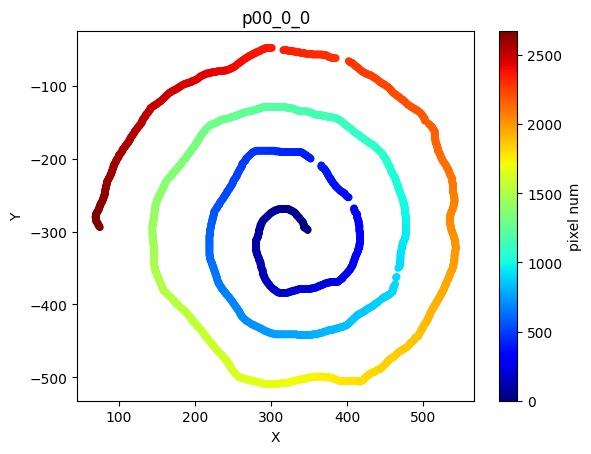

p00_0_1
p00_0_2
p00_0_3
p00_1_0
p00_1_1
p00_1_2
p00_1_3
p01_0_0
p01_0_1
p01_0_2
p01_0_3
p01_1_0
p01_1_1
p01_1_2
p01_1_3
p02_0_0
p02_0_1
p02_0_2
p02_0_3
p02_1_0
p02_1_1
p02_1_2
p02_1_3
p03_0_0
p03_0_1
p03_0_2
p03_0_3
p03_1_0
p03_1_1
p03_1_2
p03_1_3
p04_0_0
p04_0_1
p04_0_2
p04_0_3
p04_1_0
p04_1_1
p04_1_2
p04_1_3
p05_0_0
p05_0_1
p05_0_2
p05_0_3
p05_1_0
p05_1_1
p05_1_2
p05_1_3
p06_0_0
p06_0_1
p06_0_2
p06_0_3
p06_1_0
p06_1_1
p06_1_2
p06_1_3
p07_0_0
p07_0_1
p07_0_2
p07_0_3
p07_1_0
p07_1_1
p07_1_2
p07_1_3
p08_0_0
p08_0_1
p08_0_2
p08_0_3
p08_1_0
p08_1_1
p08_1_2
p08_1_3
p09_0_0
p09_0_1
p09_0_2
p09_0_3
p09_1_0
p09_1_1
p09_1_2
p09_1_3
p10_0_0
p10_0_1
p10_0_2
p10_0_3
p10_1_0
p10_1_1
p10_1_2
p10_1_3


In [5]:
names = []
trace_distances_all = []
trace_angle_all = []
all_paths = []
first = True

for name in df:
    print(name)
    # the red color threshold should not be hardcoded
    tmp = np.array((df[name] < [190, 0, 0]) * 255, dtype=np.uint16)
    #print(tmp.shape)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY)
    _, tmp = cv2.threshold(tmp, 50, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel)
    
    kernel = np.ones((3,3),np.uint8)
    tmp = cv2.dilate(tmp,kernel,iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_CLOSE, kernel)
    
    tmp = skeletonize(tmp)
    skeleton_img_cropped = np.array(tmp*1, np.uint8)
    # find center/start_point of the spiral
    spiral_start = find_spiral_point(skeleton_img_cropped, point=(0, 0), first=True, search_radius=200)
    if not spiral_start:
        print('not possible to extract')
        plt.imshow(img)
        plt.show()
        continue
    # follow the start point through the spiral
    skeleton_img_trace = skeleton_img_cropped.copy()
    trace_path = trace_spiral(skeleton_img_trace, spiral_start, search_radius=70, neigbor=False, flipped_priority=True) #, search_radius=200)
    trace_path_typed = List()
    [trace_path_typed.append(i) for i in trace_path]

    # turn the coordinates in angle and distance for an alternative representation
    trace_angle, trace_distances = get_angle_dist2(trace_path_typed)
    
    trace_angle_all.append(trace_angle)
    trace_distances_all.append(trace_distances)
    names.append(name)
    all_paths.append(trace_path)

    if first:
        plt.imshow(tmp, 'grey')
        plt.show()
        plt_traced(trace_path, name)
    first = False

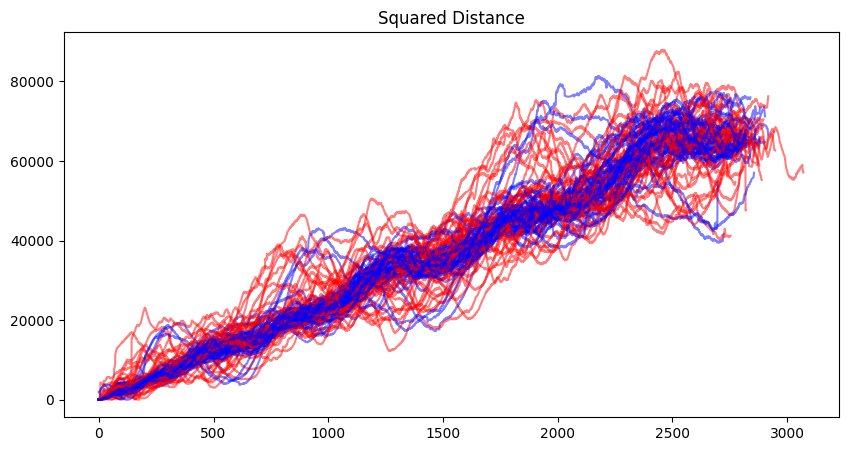

In [6]:
df = {}

plt.figure(figsize=(10, 5))
for d2, name in zip(trace_distances_all, names):
    df[name] = {}
    x = np.array([k for k in range(len(d2))]).reshape((-1, 1))
    reg = LinearRegression().fit(x, d2)
    pred = reg.predict(x)
    pad = 0
    d2 = list([0.0 for _ in range(pad)]) + list(d2)
    #print(d2)
    filtered = gaussian_filter1d(d2, 30)[pad:]
    d2 = d2[pad:]
    
    color = 'red' if name[4]=='0' else 'blue'
    plt.plot(d2[:], c=color, alpha=0.5)

    df[name]['dist2'] = d2
    df[name]['dist2_filtered'] = filtered
        
plt.title('Squared Distance')
plt.show()

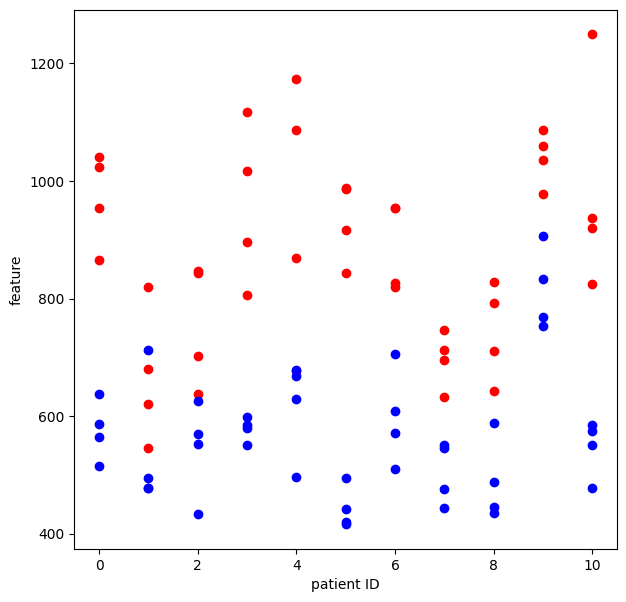

In [7]:
plt.figure(figsize=(7,7))
for name in df:
    sd, ed = 10, -5
    c = 'red' if name[4]=='0' else 'blue'
    x = float(name[1:3])
    y = feature_metric(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])
    plt.scatter(x, y, c=c)
    #plt.text(x*1.01, y*1.01, name[:3], fontsize=7)
#plt.xlim((1000, 4000))
#plt.ylim((300, 2000))
plt.xlabel('patient ID')
plt.ylabel('feature')
plt.show()

In [8]:
X_train, X_test = [], []
y_train, y_test = [], []

for b in [True, False]:
    tmpX, tmpy = [], []
    df_rand = list(df.keys())
    random.seed(31415)
    random.shuffle(df_rand) #TODO random split is bad, we should take patient ID into account 
    for name in df_rand:
        if ((name[4]=='0') == b):
            sd, ed = 10, -5
            lbl = 1 if name[4]=='0' else 0
            x = feature_metric(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])
            tmpX.append([x])
            tmpy.append(lbl)
    
    X_test.extend(tmpX[-len(tmpX)//3:])
    X_train.extend(tmpX[:-len(tmpX)//3])
    y_test.extend(tmpy[-len(tmpy)//3:])
    y_train.extend(tmpy[:-len(tmpy)//3])

In [9]:
clf = LinearDiscriminantAnalysis()

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

acc_test = 100 * (cm_test[0, 0] + cm_test[1, 1]) / sum(sum(cm_test))
print(f'test accuracy: {acc_test:.2f}%')

[[15  0]
 [ 2 13]]
test accuracy: 93.33%


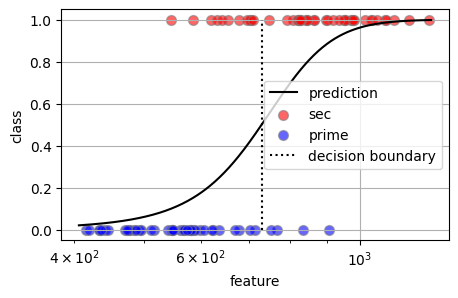

In [10]:
plt.figure(figsize=(5,3))
xmin = int(min(X_train + X_test)[0])-10
xmax = int(max(X_train + X_test)[0])+10
x = [[i] for i in range(xmin, xmax, 2)]
y = 1 / (1 + np.exp(- clf.coef_* x - clf.intercept_))
plt.plot(x, y, 'k', label='prediction')

pd_lbl, c_lbl, g_lbl = False, False, False
#y_pe = np.zeros(len(x))
#y_he = np.zeros(len(x))
#intervall = 10
for name in df:
    if name[4]=='0' and not pd_lbl:
        lbl = 'sec'
        pd_lbl = True
    elif not name[4]=='0' and not c_lbl:
        lbl = 'prime'
        c_lbl = True
    else: 
        lbl = None
    sd, ed = 10, -10
    x_f = feature_metric(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])
    #if name[4]=='0':
    #    y_pe = [j if not x_f-intervall < i < x_f + intervall else j+0.02 for i, j in zip(x, y_pe)]
    #else:
    #    y_he = [j if not x_f-intervall < i < x_f + intervall else j+0.02 for i, j in zip(x, y_he)]
        
    c = 'red' if name[4]=='0' else 'blue'
    y = 1 if name[4]=='0' else 0
    plt.scatter(x_f, y, c=c, s=50, alpha=0.6, edgecolors='grey', label=lbl)

#plt.plot([xmin, xmax], [0.5, 0.5], '--k')
plt.plot([-clf.intercept_/clf.coef_[0], -clf.intercept_/clf.coef_[0]], [0, 1], ':k', label='decision boundary')
#plt.plot(x, [1-i for i in y_pe], 'r')
#plt.plot(x, y_he, 'b')
plt.grid('True')
plt.xscale('log')
plt.xlabel('feature')
plt.ylabel('class')
plt.legend(loc = 7)

### k-fold cross validation taking groups into account

(array([ 13.,   0.,  28.,   0.,  40.,   0., 112.,   0., 295.,   0.,   0.,
        129.,   0., 101.,   0., 129.,   0., 133.,   0.,  20.]),
 array([0.625  , 0.64375, 0.6625 , 0.68125, 0.7    , 0.71875, 0.7375 ,
        0.75625, 0.775  , 0.79375, 0.8125 , 0.83125, 0.85   , 0.86875,
        0.8875 , 0.90625, 0.925  , 0.94375, 0.9625 , 0.98125, 1.     ]),
 <BarContainer object of 20 artists>)

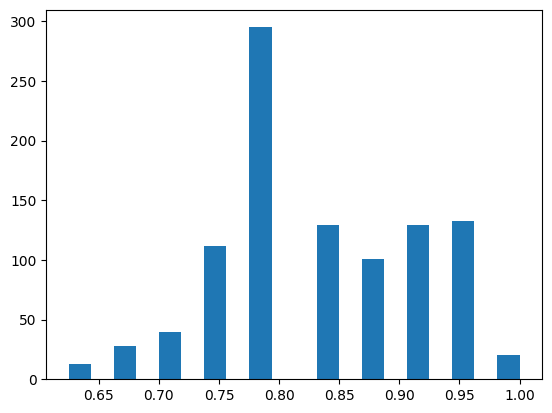

In [11]:
# Create lists for splitting with groups, makes sure that same patient doesnt end up in train and test set
primary = []
secondary = []
groups_primary = []
groups_secondary = []
for name in df:
   if name[4]=='0':
           primary.append(name)
           groups_primary.append(name[:3])
   else:
           secondary.append(name)
           groups_secondary.append(name[:3])


X = np.array(primary + secondary)
Y = np.array([1] * len(primary) + [0] * len(secondary))
groups = np.array(groups_primary + groups_secondary)

# Number of folds
k = 5

# List to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Create the model
model = LogisticRegression()


# Create k-fold cross-validation object
for seed in range(200):
    gkf = GroupShuffleSplit(n_splits=k, random_state=seed)
    #gkf = GroupKFold(n_splits=k)  # Splits the data into 5 folds


    for train_index, test_index in gkf.split(X, Y, groups):     # Split data into training and test sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
    
            X_train_data = []
            X_test_data = []
    
            for name in X_train:
                x = feature_metric(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])
                X_train_data.append([x])
                  
            for name in X_test:
                x = feature_metric(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])
                X_test_data.append([x])
                        
            # Fit the model
            model.fit(X_train_data, y_train)
        
            # Predict on the test set
            y_pred = model.predict(X_test_data)
            y_pred_prob = model.predict_proba(X_test_data)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1]) # y_pred_prob is the probability of the positive class
            
    
    
            # Calculate and store the results
            accuracies.append(accuracy_score(y_test, y_pred))
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))
            roc_aucs.append(auc(fpr, tpr))


plt.hist(accuracies, bins=20)



(array([ 1.,  2.,  1.,  4.,  4., 10.,  3., 10.,  4., 32., 10., 29., 24.,
         9., 19.,  7., 14., 11.,  2.,  2.,  2.]),
 array([0.74166667, 0.75      , 0.75833333, 0.76666667, 0.775     ,
        0.78333333, 0.79166667, 0.8       , 0.80833333, 0.81666667,
        0.825     , 0.83333333, 0.84166667, 0.85      , 0.85833333,
        0.86666667, 0.875     , 0.88333333, 0.89166667, 0.9       ,
        0.90833333, 0.91666667]),
 <BarContainer object of 21 artists>)

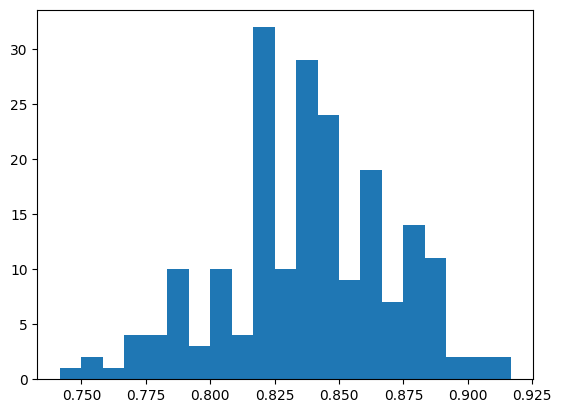

In [12]:
tmp = [np.mean(accuracies[i:i+5]) for i in range(len(accuracies)//5)]

plt.hist(tmp, bins=21)

In [13]:
print('accuracies   mean: ', round(np.mean(accuracies), 4), ';  std:  ', np.std(accuracies))
print('precisions   mean: ', round(np.mean(precisions), 4), ';  std:  ', np.std(precisions))
print('recalls      mean: ', round(np.mean(recalls), 4), ';  std:  ', np.std(recalls))
print('f1_scores    mean: ', round(np.mean(f1_scores), 4), ';  std:  ', np.std(f1_scores))
print('roc_aucs    mean: ', round(np.mean(roc_aucs), 4), ';  std:  ', np.std(roc_aucs))

for i in [accuracies, precisions, recalls, f1_scores, roc_aucs]:
    print(round(np.std(i), 3), end='')
    print('& ', end='')

accuracies   mean:  0.8342 ;  std:   0.08343239944876198
precisions   mean:  0.8989 ;  std:   0.12717863031185184
recalls      mean:  0.7926 ;  std:   0.16393340026432143
f1_scores    mean:  0.8219 ;  std:   0.0984452635707366
roc_aucs    mean:  0.9435 ;  std:   0.05598048214143066
0.083& 0.127& 0.164& 0.098& 0.056& 

[6.59805325e-01 9.32573504e-01 8.86450811e-01 1.90727107e-01
 7.67575591e-01 5.44605334e-01 1.73894656e-01 2.61138962e-01
 5.16788759e-02 1.79812369e-01 4.09157972e-02 4.00186426e-04
 5.34416686e-01 9.74597304e-01 9.71810969e-01 9.74942051e-01
 8.79970924e-01 9.84087283e-01 9.86179957e-01 9.70911737e-01
 9.29905564e-01 8.91695246e-01 9.76117291e-01 9.01704092e-01]


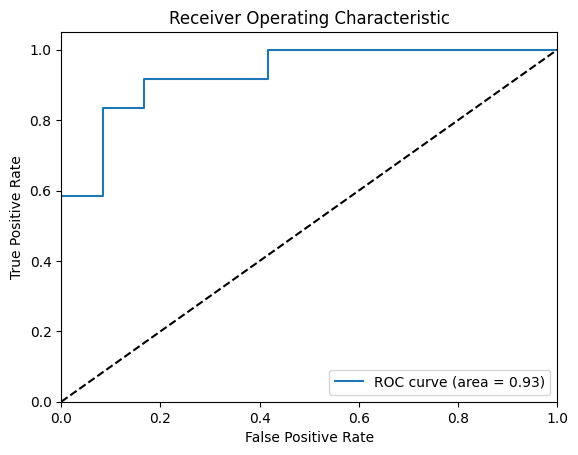

In [14]:
print(y_pred_prob[:,0])
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1]) # y_pred_prob is the probability of the positive class
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

